# Time Series Forecasting

## Predicting the Future Customers in a shop

We will use the time series models to forecast the future customers visiting the shop.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Customers_in_a_Shop.csv', header=None)
data.columns = ['Date', 'Customers']
data.head()

,Date,Customers
0,1949-01,114.0
1,1949-02,120.0
2,1949-03,134.0
3,1949-04,67.0
4,1949-05,123.0


In [3]:
data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m')
data = data.set_index('Date')
data.head()

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Customers  140 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [5]:
data.describe()

,Customers
count,140.000000
mean,291.878571
std,150.040592
min,34.000000
25%,180.000000
50%,265.500000
75%,364.750000
max,770.000000


### Handling the missing values

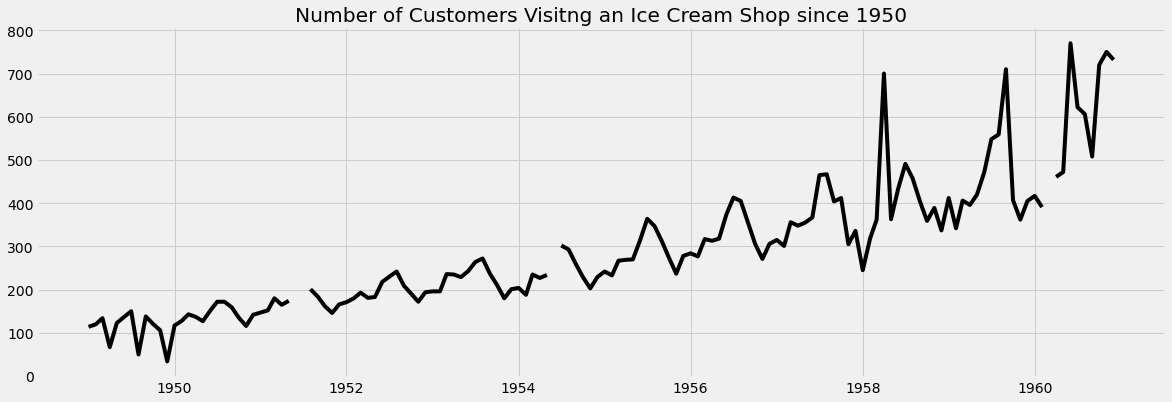

In [6]:
plt.rcParams['figure.figsize']=(18,6)
plt.plot(data, color='black')
plt.title('Number of Customers Visitng an Ice Cream Shop since 1950')
plt.show()

Here, from the above plot one can infer that there are some missing values in our time series data. We need to impute the missing values of the time series with an appropriate method to retain the trend and seasonality of the time series.

### 1. Mean Imputation

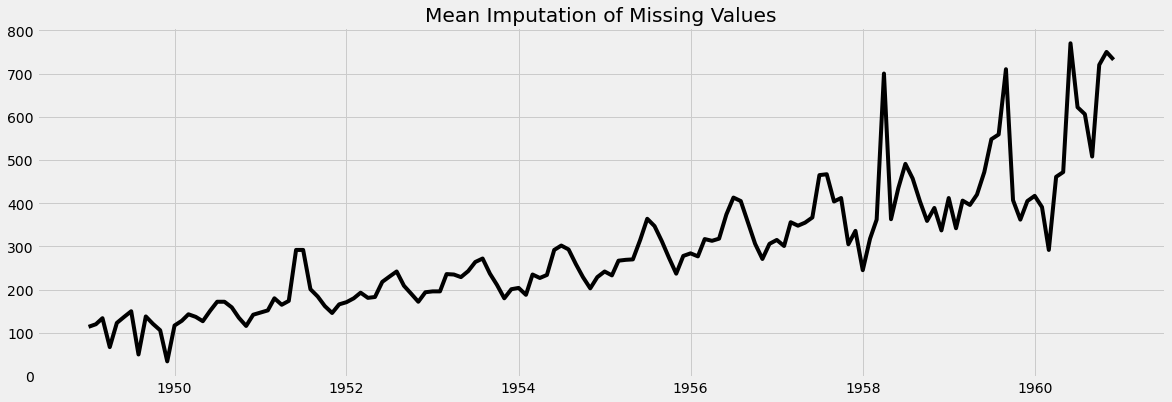

In [8]:
#Here, we fill the missing values by the mean of the data.

data['Customers_mean'] = data['Customers'].fillna(data['Customers'].mean())
plt.plot(data['Customers_mean'], color = 'black')
plt.title("Mean Imputation of Missing Values")
plt.show()

### 2. Last Observation Carried Forward

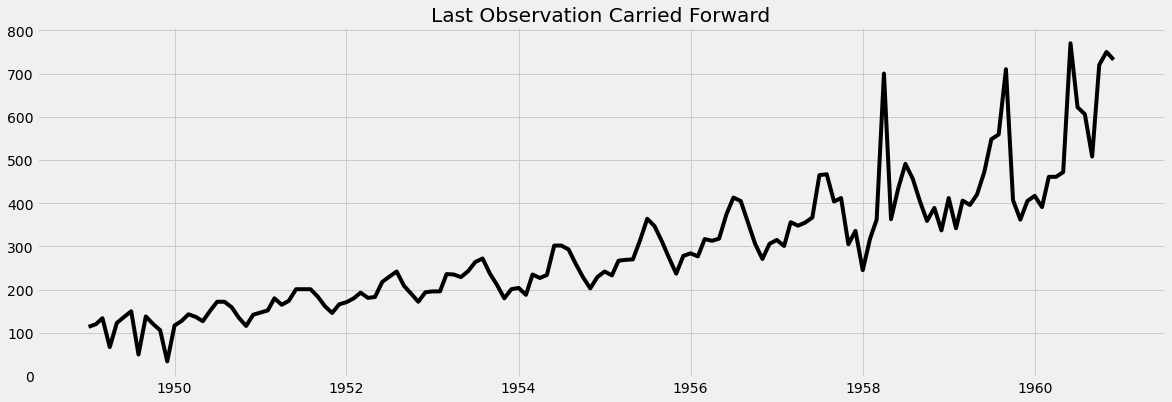

In [9]:
#Here, we impute the missing values with previous value in the data.

data['Customers_locf'] = data['Customers'].bfill()
plt.plot(data['Customers_locf'],color='black')
plt.title("Last Observation Carried Forward")
plt.show()


### 3. Linear Interpolation

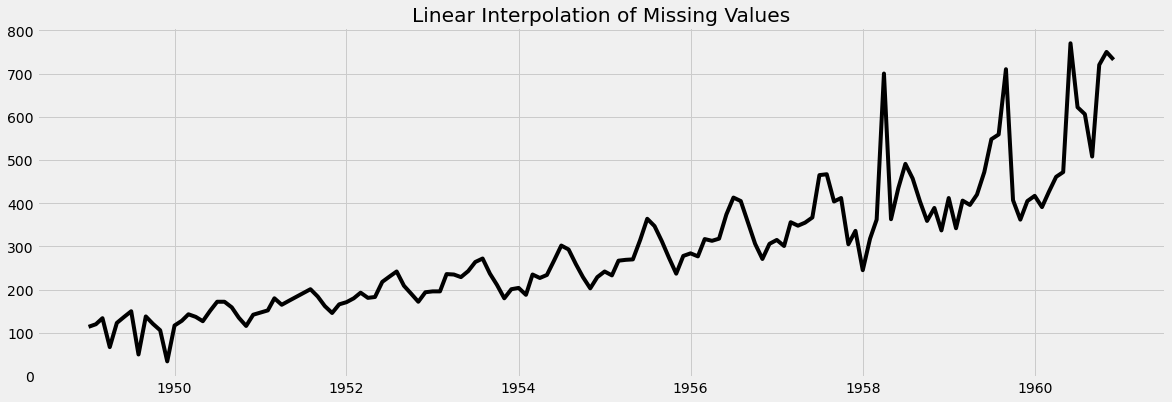

In [10]:
#Here, we draw a straight line joining the previous and next points of the missing values.

data['Customer_linear'] = data['Customers'].interpolate(method = 'linear')
plt.plot(data['Customer_linear'], color='black')
plt.title('Linear Interpolation of Missing Values')
plt.show()

Out of all the above methods of imputing missing values, Linear Interpolation works best for this time series retaining the trend as well as the seasonality of the data. So we proceed with the Linear Interpolation method.



In [12]:
data['Customers'] = data['Customer_linear']

### Checking for Outliers

### Box Plot

### Box plot is the standard way of displaying the distribution of data. Any data points which are <b> less than Q1 - 1.5IQR or greater than Q3 + 1.5IQR </b> are considered to be outliers.

where,
  * IQR is InterQuartile Range (Q3 - Q1)

<AxesSubplot:xlabel='Customer_linear'>

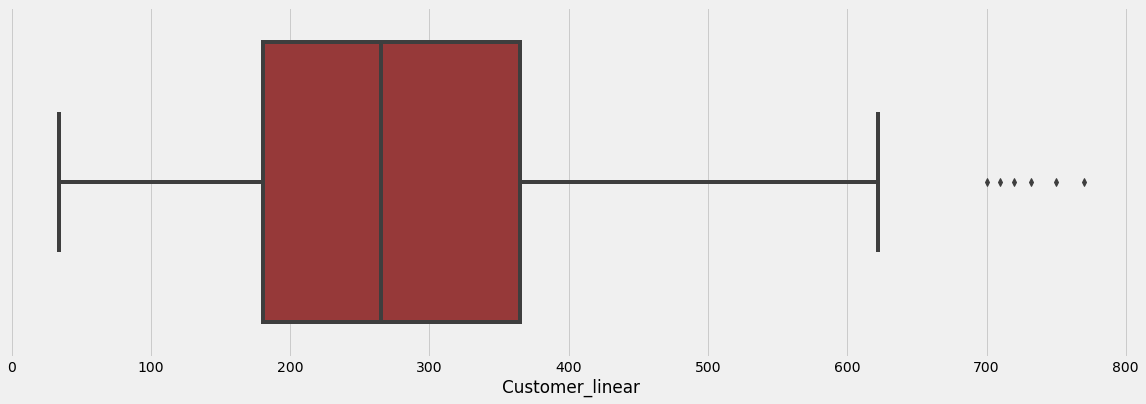

In [14]:
sns.boxplot(data['Customer_linear'], color = 'brown')

From the above plot, one can observe that the data contains some outliers in it. There can be some period where the number of customers visiting the shop are quite higher. These points can be useful to us but these are outliers so we cap them and get rid of the outliers.

In [16]:
data['Customer_linear'].loc[(data['Customer_linear'] >= 700)] = 622

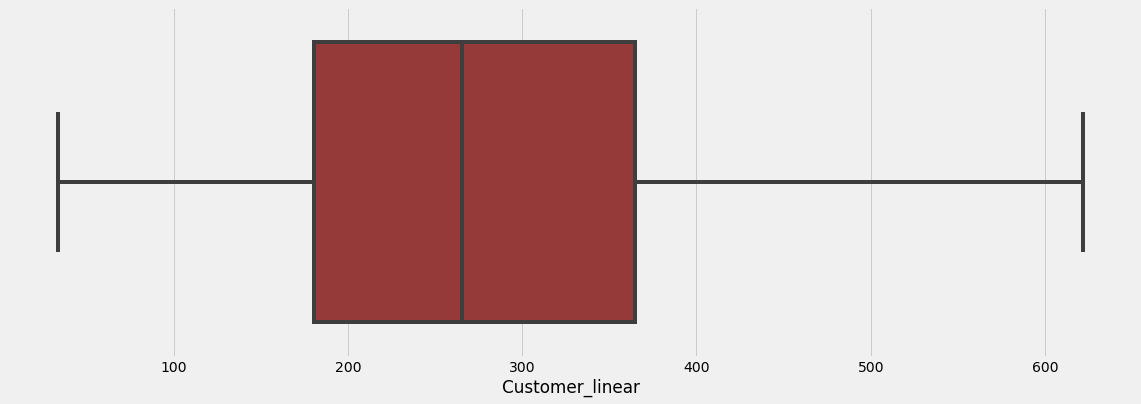

In [18]:
sns.boxplot(data['Customer_linear'], color='brown')
plt.show()

### Time Series Decomposition

In [19]:
import statsmodels.api as sm

### Multiplicative Seasonal Decomposition

Multiplicative Seasonal Decomposition is when we multiply the individual components to get the time series data.

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
decomposition = seasonal_decompose(data['Customer_linear'], model="mul")

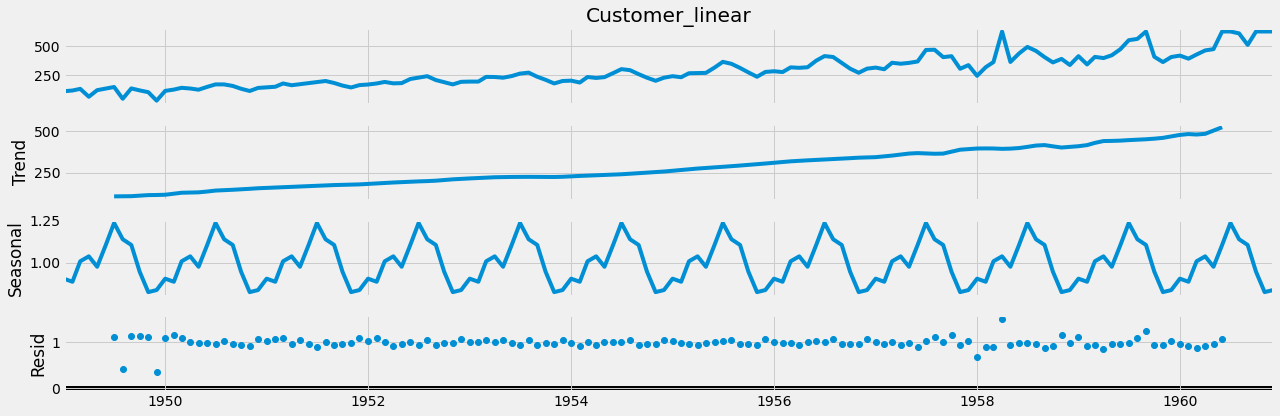

In [23]:
fig = decomposition.plot()

The time series is formed by multiplying all the individual components. So, we need to go for the model which takes care of <b> Level, Trend and Seasonality. </b>

We have two such models:

    1. Holt Winter Exponential Smoothing
    2. SARIMA Model

### Splitting into Train and Test Data

In [24]:
length_train = 115
train = data.iloc[:length_train,:]
test = data.iloc[length_train:, :]

In [26]:
train.shape

(115, 4)

In [27]:
train.tail()

,Customers,Customers_mean,Customers_locf,Customer_linear
Date,,,,
1958-03-01,362.0,362.0,362.0,362.0
1958-04-01,700.0,700.0,700.0,622.0
1958-05-01,363.0,363.0,363.0,363.0
1958-06-01,435.0,435.0,435.0,435.0
1958-07-01,491.0,491.0,491.0,491.0


In [28]:
test.shape

(29, 4)

In [29]:
test.head()

,Customers,Customers_mean,Customers_locf,Customer_linear
Date,,,,
1958-08-01,457.0,457.0,457.0,457.0
1958-09-01,404.0,404.0,404.0,404.0
1958-10-01,359.0,359.0,359.0,359.0
1958-11-01,389.0,389.0,389.0,389.0
1958-12-01,337.0,337.0,337.0,337.0


### Holt Winter Exponential Smoothing

This techniques forecasts based on level, trend and seasonality. The forecast equation for this method includes seasonality.

y(t+1) = l(t)+b(t)+s(t+1-m)

where,

* m is the number of time a season repeats in a timeperiod.

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [32]:
model = ExponentialSmoothing(train['Customers'], seasonal_periods=12, trend='mul', seasonal='add')
model_fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.04)
model_fit.params

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.2,
 'smoothing_trend': 0.04,
 'smoothing_seasonal': 0.7485292092203322,
 'damping_trend': nan,
 'initial_level': 437.2961746706447,
 'initial_trend': 1.0043072720145452,
 'initial_seasons': array([-326.43527652, -317.68643465, -301.18819033, -361.84967405,
        -319.82418374, -302.36625728, -286.16797731, -376.97724617,
        -314.61126049, -331.46408613, -344.30110473, -406.02653952]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [33]:
y_holtwinter = test.copy()
y_holtwinter['holtwinter_forecast'] = model_fit.forecast(36)

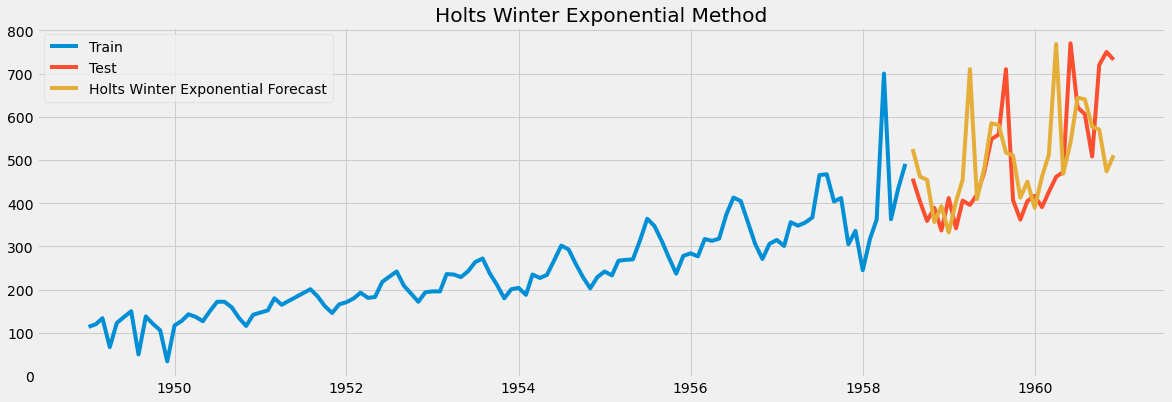

In [34]:
plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_holtwinter['holtwinter_forecast'], label = 'Holts Winter Exponential Forecast')

plt.legend()
plt.title('Holts Winter Exponential Method')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error

mfe = np.round(np.mean(test['Customers'] - y_holtwinter['holtwinter_forecast']), 2)
mae = np.round(np.mean(np.abs(test['Customers']-y_holtwinter['holtwinter_forecast'])),2)
mape = np.round(np.mean(np.abs(test['Customers']-y_holtwinter['holtwinter_forecast'])/test['Customers'])*100,2)
rmse = np.round(np.sqrt(mean_squared_error(test['Customers'], y_holtwinter['holtwinter_forecast'])),2)

result = pd.DataFrame({'mfe': mfe, 'mae': mae, 'mape': mape, 'rmse': rmse}, index = [0])
result

,mfe,mae,mape,rmse
0,-11.54,95.93,19.14,131.49


We achieved good result but let's see if we can improve our forecasted values. So, next we would use SARIMA Model. Before using SARIMA model we need to take care of the assumptions of the SARIMA Model. So, lets check if the time series is stationary or not.

### Stationarity

Stationarity means that the statistical properties of a process generating a time series do not change over time. The statistical properties are Mean, variance and covariance which are same irrespective of the time at which you observe them.

Stationarity is an important concept as stationary processes are easier to analyze and model because their statistical properties do not change over time.

### Augmented Dickey-Fuller Test for Stationarity

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [38]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Customer_linear'], autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 2.7105600112832824
n_lags: 0.9990875034273379
p-value: 0.9990875034273379
Critial Values:
   1%, -3.482087964046026
Critial Values:
   5%, -2.8842185101614626
Critial Values:
   10%, -2.578864381347275


* p-value is 1 and its value is larger than 0.05 , hence 
it fails to reject the null hypothesis. Hence, the data has a unit root and is non-stationary

* The mean value is not stationary.
* The variance is fluctating over time.

### Converting Non Stationarity Series into Stationary

We have two method for converting a non stationary series into a stationary series:-
1. Box Cox transformation
2. Differencing

### BOX COX transformation 

A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn't normal, applying a Box-Cox means that you are able to run a broader number of tests.

In [39]:
from scipy.stats import boxcox


In [41]:
boxcox(data['Customer_linear'], lmbda = 0)

array([4.73619845, 4.78749174, 4.8978398 , 4.20469262, 4.81218436,
       4.91998093, 5.01063529, 3.91202301, 4.92725369, 4.79579055,
       4.66343909, 3.52636052, 4.76217393, 4.85203026, 4.96284463,
       4.91998093, 4.84418709, 5.01727984, 5.14749448, 5.14749448,
       5.0689042 , 4.90527478, 4.75359019, 4.95582706, 4.99043259,
       5.02388052, 5.19295685, 5.10594547, 5.1590553 , 5.20948615,
       5.25749537, 5.30330491, 5.21493576, 5.08759634, 4.98360662,
       5.11198779, 5.14166356, 5.19295685, 5.26269019, 5.19849703,
       5.20948615, 5.38449506, 5.43807931, 5.48893773, 5.34233425,
       5.25227343, 5.14749448, 5.26785816, 5.27811466, 5.27811466,
       5.46383181, 5.45958551, 5.433722  , 5.49306144, 5.5759491 ,
       5.60580207, 5.46806014, 5.35185813, 5.19295685, 5.30330491,
       5.31811999, 5.23644196, 5.45958551, 5.42495002, 5.45532112,
       5.59098698, 5.71042702, 5.68017261, 5.55682806, 5.433722  ,
       5.31320598, 5.433722  , 5.48893773, 5.45103845, 5.58724

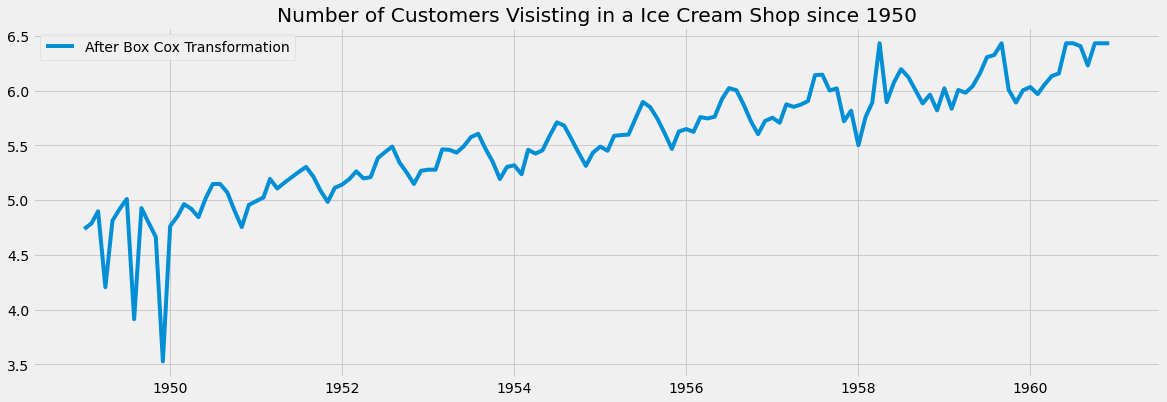

In [42]:
data_boxcox = pd.Series(boxcox(data['Customer_linear'], lmbda = 0), index = data.index)
plt.plot(data_boxcox, label="After Box Cox Transformation")
plt.legend(loc='best')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

### Differencing

Differencing stabilises the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. 

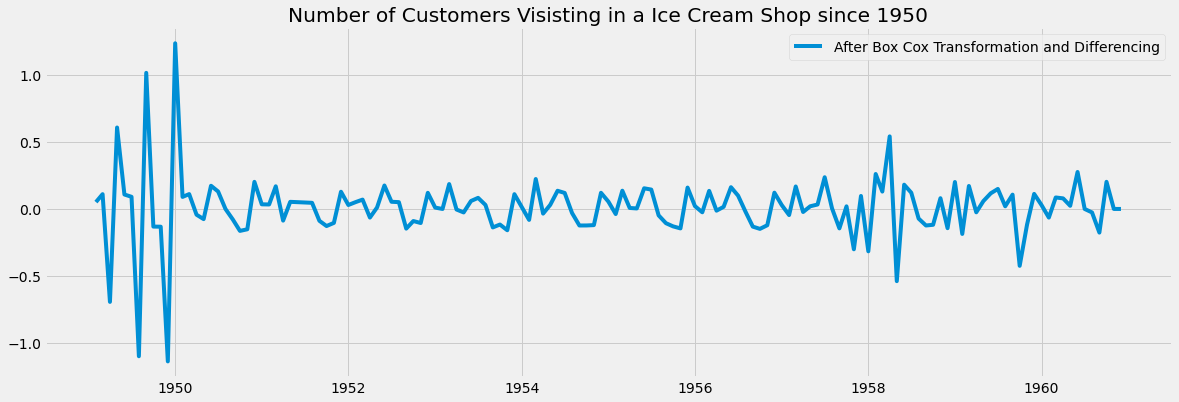

In [43]:
data_boxcox_difference = pd.Series(data_boxcox - data_boxcox.shift(), index = data.index)
data_boxcox_difference.dropna(inplace=True)
plt.plot(data_boxcox_difference, label="After Box Cox Transformation and Differencing")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

### Checking for Stationarity again

### ADF Test

In [44]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_boxcox_difference, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]:.20f}')
print(f'p-value: {result[1]:.20f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.770270241136213
n_lags: 0.00000000000000000000
p-value: 0.00000000000000000000
Critial Values:
   1%, -3.4808880719210005
Critial Values:
   5%, -2.8836966192225284
Critial Values:
   10%, -2.5785857598714417


p-value is less than 0.05, hence it rejects the Null Hypothesis which implies that it is now stationary.

### AutoCorrelation Function

ACF is an complete auto-correlation function which gives us values of auto-correlation of any series with its lagged values.

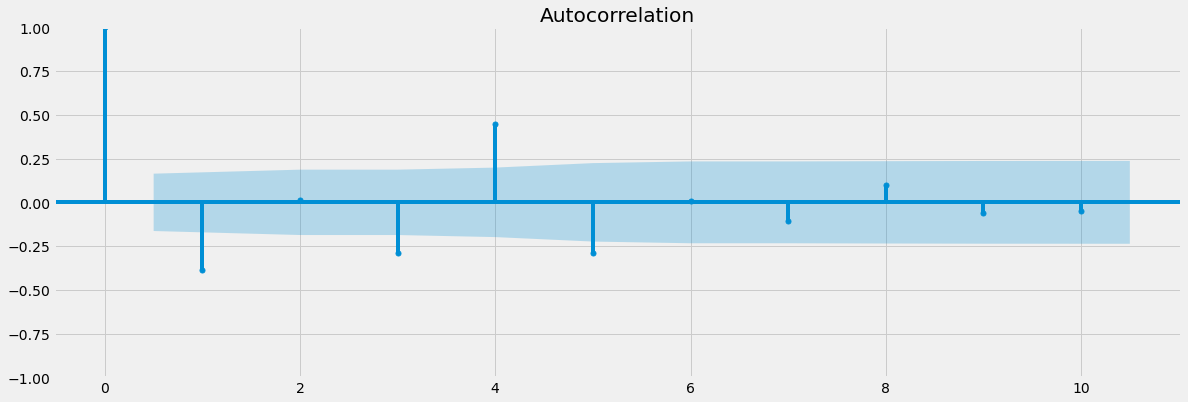

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_difference, ax = plt.gca(), lags = 10)
plt.show()

### Partial Auto Correlation Function

PACF gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

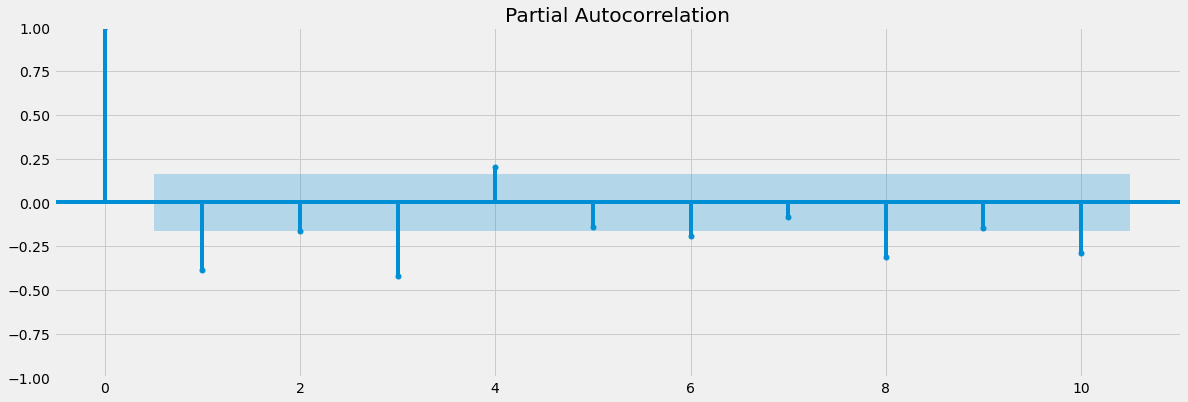

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_boxcox_difference, ax = plt.gca(), lags = 10)
plt.show()

### Splitting into Train and Test data

In [48]:
train_data_boxcox = data_boxcox[:length_train]
test_data_boxcox = data_boxcox[length_train:]
train_data_boxcox_difference = data_boxcox_difference[:length_train-1]
test_data_boxcox_difference = data_boxcox_difference[length_train-1:]  

## Seasonal Auto Regressive Integrated Moving Average Model (SARIMA)

SARIMA model brings all the features of ARIMA model along with the seasonality.

The key elements performed in SARIMA are:-

1. The time series is differenced to make it stationary.

2. The SARIMA equation is a linear combination of past observations and past errors.

3. Seasonal differencing is performed on the time series.

4. SARIMA models future seasonality as a linear combination of past seasonality observations and past seasonality errors

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox_difference, order = (1, 1, 1), seasonal_order = (1, 1, 1, 6))
model_fit = model.fit()
model_fit.params

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1     -0.577420
ma.L1     -0.998250
ar.S.L6   -0.734243
ma.S.L6   -0.540078
sigma2     0.049817
dtype: float64

### Recover Time Series Data

In [50]:
y_sarima_new = test_data_boxcox_difference.copy()
y_sarima_new['sarima_forecast_boxcox_difference'] = model_fit.predict(test_data_boxcox_difference.index.min(), test_data_boxcox_difference.index.max())
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox_difference'].cumsum()
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox'].add(test_data_boxcox[0])
y_sarima_new['sarima_forecast'] = np.exp(y_sarima_new['sarima_forecast_boxcox'])

### Plotting Train, Test and Forecasted data

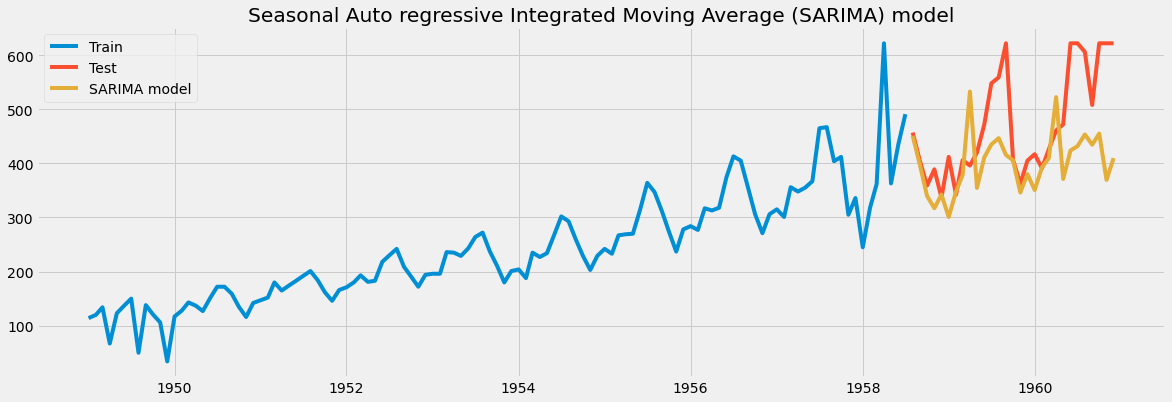

In [52]:
plt.plot(train['Customer_linear'], label = 'Train')
plt.plot(test['Customer_linear'], label = 'Test')
plt.plot(y_sarima_new['sarima_forecast'][test.index.min():], label = 'SARIMA model')

plt.legend()
plt.title('Seasonal Auto regressive Integrated Moving Average (SARIMA) model')
plt.show()

### Evaluating the model

In [53]:
from sklearn.metrics import mean_squared_error
mfe = np.round(np.mean(test['Customers']-y_sarima_new['sarima_forecast']),2)
mae = np.round(np.mean(np.abs(test['Customers']-y_sarima_new['sarima_forecast'])),2)
mape = np.round(np.mean(np.abs(test['Customers']-y_sarima_new['sarima_forecast'])/test['Customers'])*100,2)
rmse = np.round(np.sqrt(mean_squared_error(test['Customers'],y_sarima_new['sarima_forecast'])),2)

result = pd.DataFrame({'mfe':mfe,'mae':mae,'mape':mape, 'rmse':rmse}, index=[0])
result

,mfe,mae,mape,rmse
0,90.81,105.38,17.99,153.18
